In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import train_test_split
import datetime as dt
import statsmodels.api as sm
from cvxopt import matrix , solvers , spdiag,mul , log, div ,exp
import scipy.linalg as la
from scipy.special import erf

## Deviance statistic:
### $D=2 \sum_{i=1}^{n}\left(y_{i} \log \left(\frac{y_{i}}{\exp \left\{\mathbf{X}_{i} \hat{\beta}\right\}}\right)-\left(y_{i}-\exp \left\{\mathbf{X}_{i} \hat{\beta}\right\}\right)\right)$


# Generate data

In [2]:
mean_X = np.random.uniform(low = 2,high = 20,size = 200)

In [3]:
var_X = np.random.uniform(0.0,0.5,size = 200)

In [4]:
coef = [0.8,-8]

In [5]:
X = []
y = []
for u, v in zip(mean_X,var_X):
    shared_x = []
    shared_y = []
    for i in range(30):
        temp_x = np.random.normal(u,v)
        temp_y = np.random.poisson(np.exp(coef[0]*u+coef[1]))
        shared_x.append(temp_x)
        shared_y.append(temp_y)
    X.append(shared_x)
    y.append(shared_y)
X = np.array(X).reshape(-1,1)
y = np.array(y).reshape(-1)

In [6]:
X = np.hstack([X,np.ones((6000,1))])

In [7]:
def laplace_inv(k):
    arr=[]
    Phi = lambda x: (erf(x/2**0.5))/2
    for i in range (-500,500,1):
        if np.abs(Phi(i/100.0)-(k-0.5)) < 0.01:
            arr.append(i)
    return sum(arr)/(100*len(arr))
def model(meanA,varA,beta,m,b,y_mu,intial,alpha): 
    k1 = 1.0/laplace_inv((beta+1)/2) 
    k2 = 1.0/laplace_inv((1-beta)/2) 
    test=np.array(meanA)
    n = m
    l = len(test)
    A = test[0:int(l/2),:]
    print(A.shape)
    q=[0.0]*int(l/2)
    y_mu=matrix([0]*b+y_mu)
    y_hs=matrix([0]*b+[1]*(n-b))
    
    check1 = []
    check2 = []
    h = []
    meanA1 = k1*np.array(meanA[0:int(l/2),:])
    meanA2 = k2*np.array(meanA[int(l/2):l,:])
    meanA = np.concatenate((meanA1,meanA2))
    varA=np.array(varA)
        # Dùng list để lưu lại các ma trận hệ số sau khi đưa về dạng chính tắc của các ràng buộc căn 
    for i in range(0,l):
        eigvals,eigvecs=la.eig(np.reshape(varA[i,:],(n,n)))
        g=-np.multiply(eigvecs,np.sqrt(eigvals)).T
        check1.append(g)
    for i in range(0,l):
        mt=np.vstack((np.reshape(meanA[i,:],(1,n)),check1[i])).T
        check2.append(np.array(mt,dtype=np.float32))
    G=[matrix( check2[0].tolist()) ]
    for i in range(1,l):
        G+=[ matrix( check2[i].tolist()) ]
    for i in range(0,int(l/2)):
        h.append(matrix([[k1*alpha]+[0.0]*n]))
    for i in range(0,int(l/2)):
        h.append(matrix([[(-1)*k2*alpha]+[0.0]*n ]))
    def F(x = None, z = None):
        if x is None:  return 0, matrix(intial, (n,1))
        u = exp(x)
        val = -sum(mul(y_mu,x)-mul(y_hs,u)) 
        Df = (-1*y_mu+mul(y_hs,u)).T

        if z is None:  return val, Df
        H = spdiag( z[0] * mul(y_hs,u))
        #H = z[0] * (y_hs*exp(x))/(u**2)
        return val, Df, H
    dims = {'l': 0, 'q': ((n+1)*np.ones(l).astype(int)).tolist(), 's': []}
    solvers.options['show_progress'] = False
      # Hàm tìm nghiệm tối ưu 
    x = solvers.cp(F,G = matrix(G), h =matrix(h), A = matrix(A), b = matrix(q), dims = dims)['x']
    return x

In [8]:
n_estimate = 30
X_train = X[:5400]
y_train = y[:5400]

In [9]:
X_train_=pd.concat([pd.DataFrame(data=X_train), pd.DataFrame(data=np.zeros((len(X_train),180)))], ignore_index=True,axis=1)

In [10]:
var_X = []
n_c = 180
for start, end in zip(range(0, len(X_train), n_estimate), range(n_estimate-1, len(X_train), n_estimate)):
    var_X.append(X_train_[start:end+1].cov().to_numpy().reshape(-1))
var_X = np.vstack((var_X,var_X))

In [11]:
X_train_g = [] # only for training GLR
y_train_g = [] # only for training GLR
for start, end in zip(range(0, len(X_train), n_estimate), range(n_estimate-1, len(X_train), n_estimate)):
    X_train_g.append(X_train[start:end+1].mean(axis = 0))
    y_train_g.append(y_train[start:end+1].mean())

In [12]:
eyes = np.vstack([-np.eye(180),-np.eye(180)])

In [13]:
meanA = np.hstack([np.vstack([X_train_g,np.array(X_train_g)]),eyes])

In [14]:
intial = np.concatenate([[0.8,-8],np.dot(X_train_g,[0.8,-8])])

In [15]:
x= model(meanA,var_X,0.85,182,2,y_train_g,intial,0.6)

(180, 182)


<ipython-input-7-34831d37e6a8>:34: ComplexWarning: Casting complex values to real discards the imaginary part
  check2.append(np.array(mt,dtype=np.float32))


In [16]:
W = np.array(x)

In [17]:
W[0:2,:]

array([[ 0.78219353],
       [-7.65638806]])

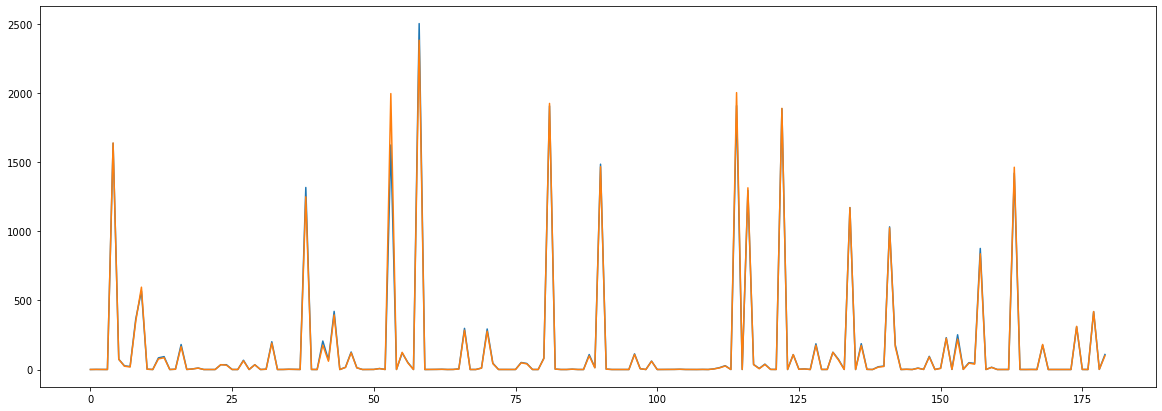

In [18]:
plt.figure(figsize=(20,7))
plt.plot(np.exp(np.dot(X_train_g,W[0:2,:])).reshape(-1))
plt.plot(y_train_g)

In [19]:
poisson_training_results = sm.GLM(y_train_g, X_train_g, family=sm.families.Poisson()).fit()
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  180
Model:                            GLM   Df Residuals:                      178
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -337.25
Date:                Sat, 07 Aug 2021   Deviance:                       110.26
Time:                        10:20:40   Pearson chi2:                     114.
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.8022      0.004    180.580      0.0

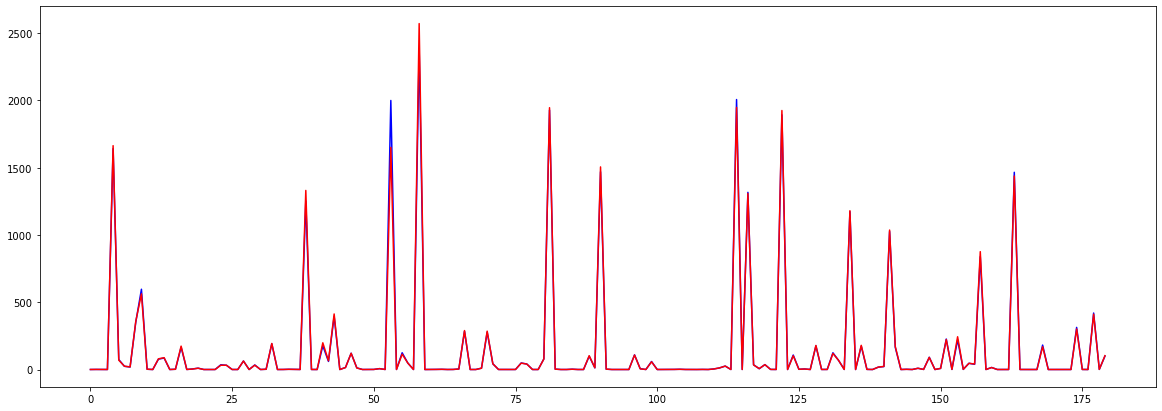

In [20]:
prediction = poisson_training_results.predict(X_train_g)
plt.figure(figsize=(20,7))
plt.plot(y_train_g,'b-')
plt.plot(prediction,'r-')